In [1]:
from dypac import Dypac
import numpy as np
import sklearn as sk
import scipy as sp
import matplotlib.pyplot as plt
import time
from nilearn import datasets
from nilearn import image
from nilearn.maskers import NiftiMasker
from nilearn.interfaces.fmriprep import load_confounds
from nilearn import plotting
from nilearn.decomposition import DictLearning, CanICA
from scipy.stats import pearsonr

Let's start by downloading a yem subjects from the developmental movie watching dataset.

In [2]:
n_subjects = 6
dev_dataset = datasets.fetch_development_fmri(n_subjects=n_subjects)
epi_filename = dev_dataset.func

In [3]:
conf, _ = load_confounds(epi_filename, strategy=["motion"], motion="basic")

Now we run dypac. First we specify the model, with the main relevant options. Then we fit the model on the developmental data.

In [4]:
model = Dypac(n_clusters=50, n_states=150, verbose=1, n_init=1, n_init_aggregation=1, n_replications=20, 
              detrend=True, smoothing_fwhm=5, standardize=True, n_batch=2, threshold_sim=0)
model.fit(epi_filename, confounds=conf)

[MultiNiftiMasker.fit] Loading data from [/home/haoting/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,
 /home/haoting/nilearn_data/development_fmri/development_fmri/sub-pixar001_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,
 /home/haoting/nilearn_data/development_fmri/development_fmri/sub-pixar002_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,
 /home/haoting/nilearn_data/development_fmri/development_fmri/sub-pixar003_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,
 /home/haoting/nilearn_data/development_fmri/development_fmri/sub-pixar004_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz,
 /home/haoting/nilearn_data/development_fmri/development_fmri/sub-pixar005_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz]
[MultiNiftiMasker.fit] Computing mask
[MultiNiftiMasker.transform] Resampling mask
[Dypac] load specified grey matter mask
[Dypac] 

Replicating clusters in data #0: 100%|███████████████████████████████| 20/20 [00:06<00:00,  3.07it/s]


[MultiNiftiMasker.transform_imgs] Loading data from Nifti1Image('/home/haoting/nilearn_data/development_fmri/development_fmri/sub-pixar002_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
[MultiNiftiMasker.transform_imgs] Smoothing images
[MultiNiftiMasker.transform_imgs] Extracting region signals
[MultiNiftiMasker.transform_imgs] Cleaning extracted signals


Replicating clusters in data #1: 100%|███████████████████████████████| 20/20 [00:06<00:00,  2.88it/s]


[MultiNiftiMasker.transform_imgs] Loading data from Nifti1Image('/home/haoting/nilearn_data/development_fmri/development_fmri/sub-pixar004_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
[MultiNiftiMasker.transform_imgs] Smoothing images
[MultiNiftiMasker.transform_imgs] Extracting region signals
[MultiNiftiMasker.transform_imgs] Cleaning extracted signals


Replicating clusters in data #2: 100%|███████████████████████████████| 20/20 [00:06<00:00,  2.90it/s]


Consensus clustering.


Trimming states: 100%|████████████████████████████████████████████| 150/150 [00:00<00:00, 767.44it/s]


[Dypac] Processing batch 1
[MultiNiftiMasker.transform_imgs] Loading data from Nifti1Image('/home/haoting/nilearn_data/development_fmri/development_fmri/sub-pixar001_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
[MultiNiftiMasker.transform_imgs] Smoothing images
[MultiNiftiMasker.transform_imgs] Extracting region signals
[MultiNiftiMasker.transform_imgs] Cleaning extracted signals


Replicating clusters in data #0: 100%|███████████████████████████████| 20/20 [00:07<00:00,  2.84it/s]


[MultiNiftiMasker.transform_imgs] Loading data from Nifti1Image('/home/haoting/nilearn_data/development_fmri/development_fmri/sub-pixar003_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
[MultiNiftiMasker.transform_imgs] Smoothing images
[MultiNiftiMasker.transform_imgs] Extracting region signals
[MultiNiftiMasker.transform_imgs] Cleaning extracted signals


Replicating clusters in data #1: 100%|███████████████████████████████| 20/20 [00:06<00:00,  3.04it/s]


[MultiNiftiMasker.transform_imgs] Loading data from Nifti1Image('/home/haoting/nilearn_data/development_fmri/development_fmri/sub-pixar005_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
[MultiNiftiMasker.transform_imgs] Smoothing images
[MultiNiftiMasker.transform_imgs] Extracting region signals
[MultiNiftiMasker.transform_imgs] Cleaning extracted signals


Replicating clusters in data #2: 100%|███████████████████████████████| 20/20 [00:06<00:00,  3.11it/s]


Consensus clustering.


Trimming states: 100%|████████████████████████████████████████████| 150/150 [00:00<00:00, 729.06it/s]


Inter-batch consensus
Generating consensus stability maps


Dypac(grey_matter='/home/haoting/nilearn_data/icbm152_2009/mni_icbm152_nlin_sym_09a/mni_icbm152_gm_tal_nlin_sym_09a.nii.gz',
      mask=<nibabel.nifti1.Nifti1Image object at 0x7fb3c4da63d0>,
      memory_level=1, n_batch=2, n_clusters=50, n_init=1, n_init_aggregation=1,
      n_replications=20, n_states=150,
      random_state=RandomState(MT19937) at 0x7FB3E82E3140, smoothing_fwhm=5,
      threshold_sim=0)

Visualize components maps.

/home/haoting/.virtualenvs/dypac/lib/python3.8/site-packages/nilearn/plotting/html_stat_map.py:217: FutureWarning: Default resolution of the MNI template will change from 2mm to 1mm in version 0.10.0
  bg_img = load_mni152_template()



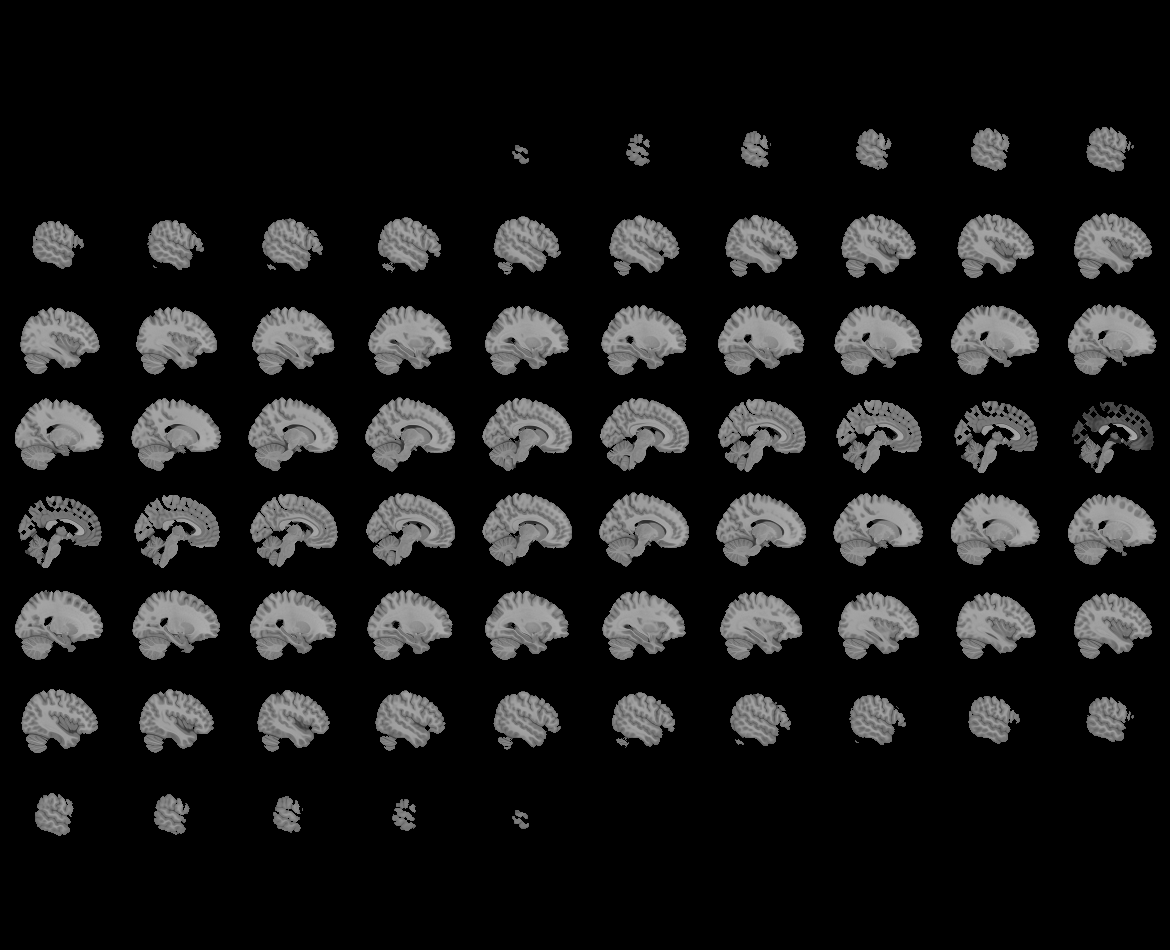
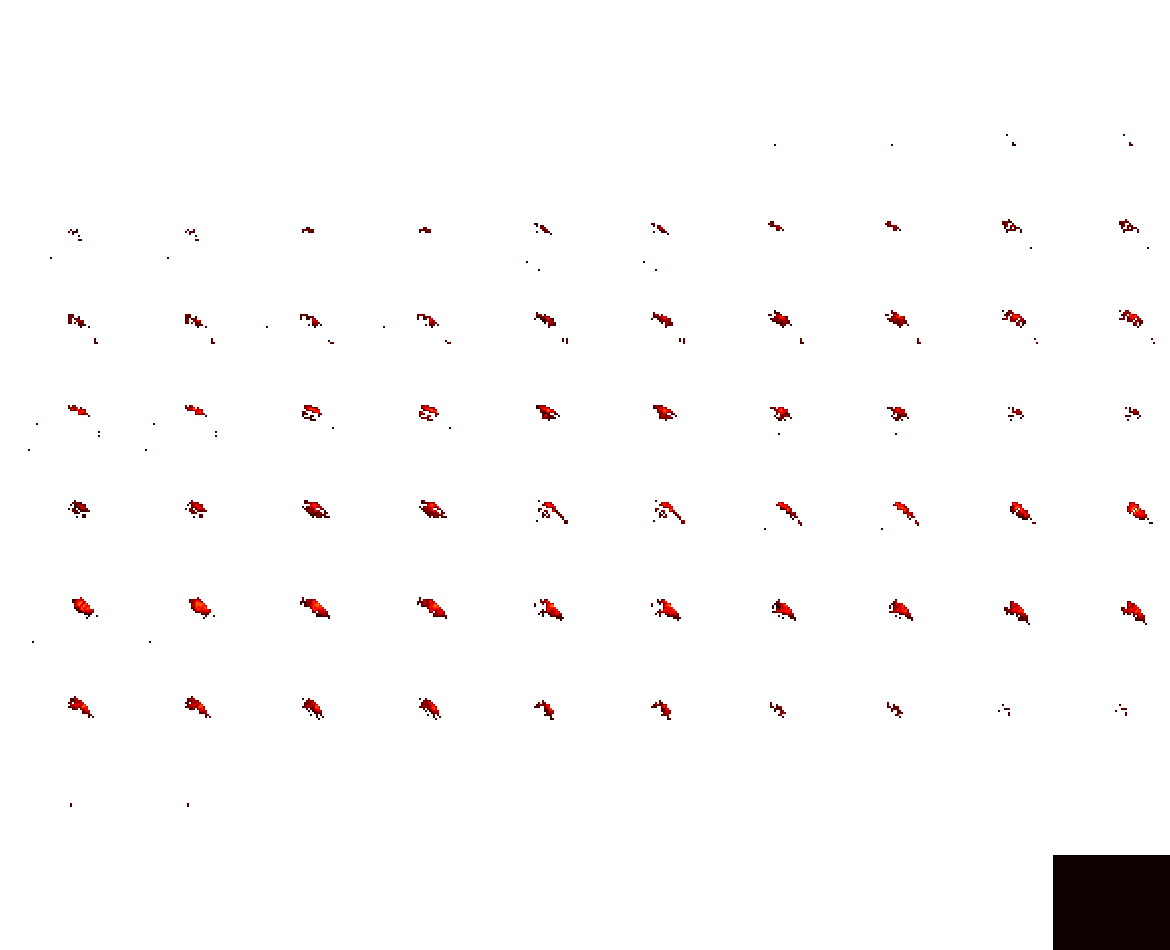

In [5]:
num_comp = 7# the component number
comp = model.masker_.inverse_transform(model.components_[num_comp,:].todense())
plotting.view_img(comp, threshold=0.1, vmax=1, title="Dwell time: {dt}".format(dt=model.dwell_time_[num_comp]))

We can project the data of one subject in the parcellation space, and visualize the time course of a parcel. Note that we shift the component index, because the first coefficient of the parcellation space corresponds to the intercept, which is not included in `components_`.

In [6]:
num_s = 0 # the subject number
weights = model.transform(epi_filename[num_s])

[MultiNiftiMasker.transform_imgs] Loading data from Nifti1Image('/home/haoting/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
[MultiNiftiMasker.transform_imgs] Smoothing images
[MultiNiftiMasker.transform_imgs] Extracting region signals
[MultiNiftiMasker.transform_imgs] Cleaning extracted signals


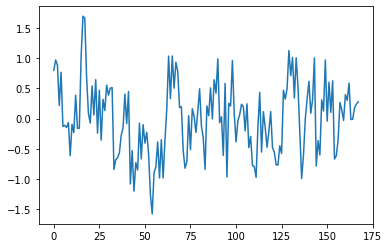

In [7]:
plt.plot(weights[:, num_comp + 1])

Let's now visualize one volume of the 4D data (after preprocessing is applied):

[MultiNiftiMasker.transform_imgs] Loading data from Nifti1Image('/home/haoting/nilearn_data/development_fmri/development_fmri/sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
[MultiNiftiMasker.transform_imgs] Smoothing images
[MultiNiftiMasker.transform_imgs] Extracting region signals
[MultiNiftiMasker.transform_imgs] Cleaning extracted signals



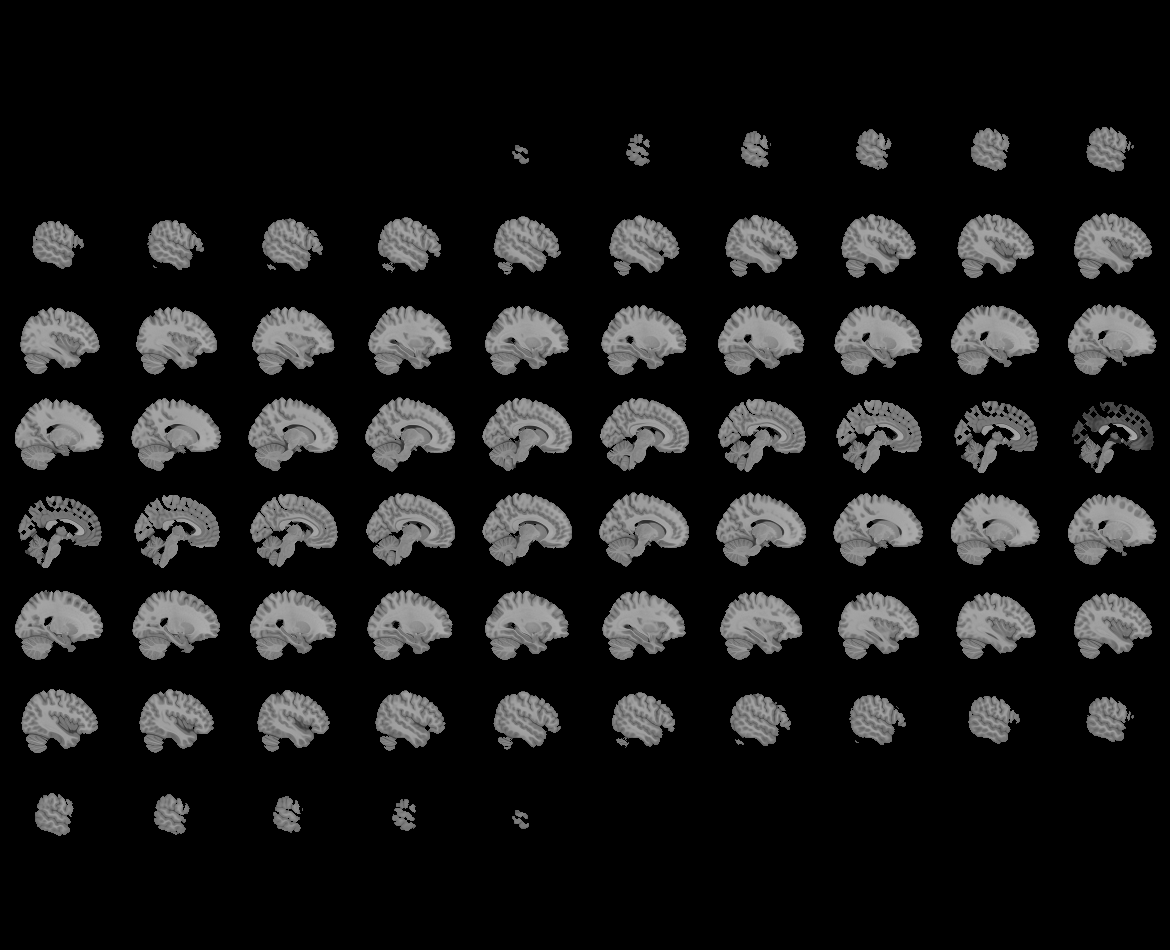
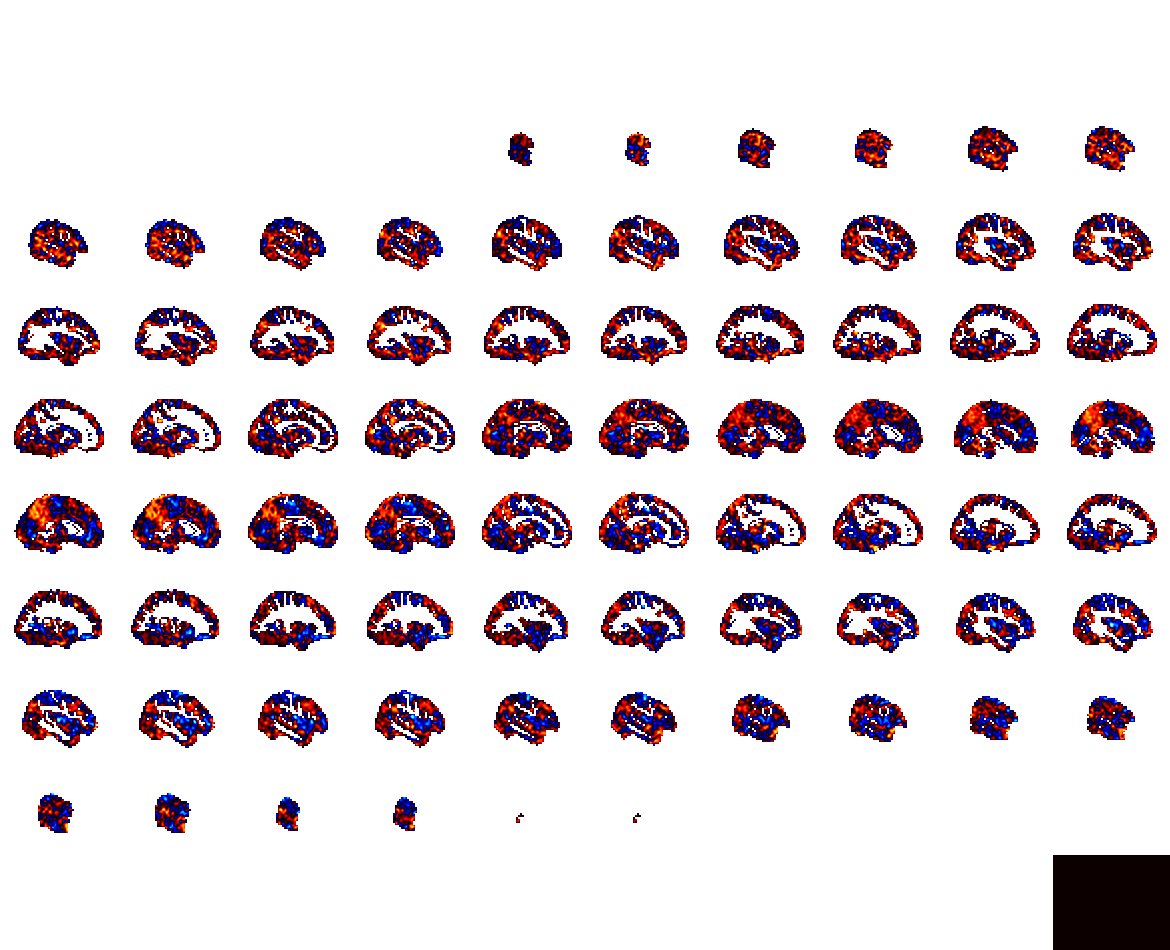

In [8]:
num_t = 65 # the frame number
img = model.load_img(epi_filename[num_s])
plotting.view_img(image.index_img(img, [num_t]), vmax=4)

We can compress the data in the parcellation space, to look if the approximation is accurate.

[MultiNiftiMasker.transform_imgs] Loading data from Nifti1Image(
shape=(50, 59, 50, 168),
affine=array([[   4.,    0.,    0.,  -96.],
       [   0.,    4.,    0., -132.],
       [   0.,    0.,    4.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[MultiNiftiMasker.transform_imgs] Smoothing images
[MultiNiftiMasker.transform_imgs] Extracting region signals
[MultiNiftiMasker.transform_imgs] Cleaning extracted signals



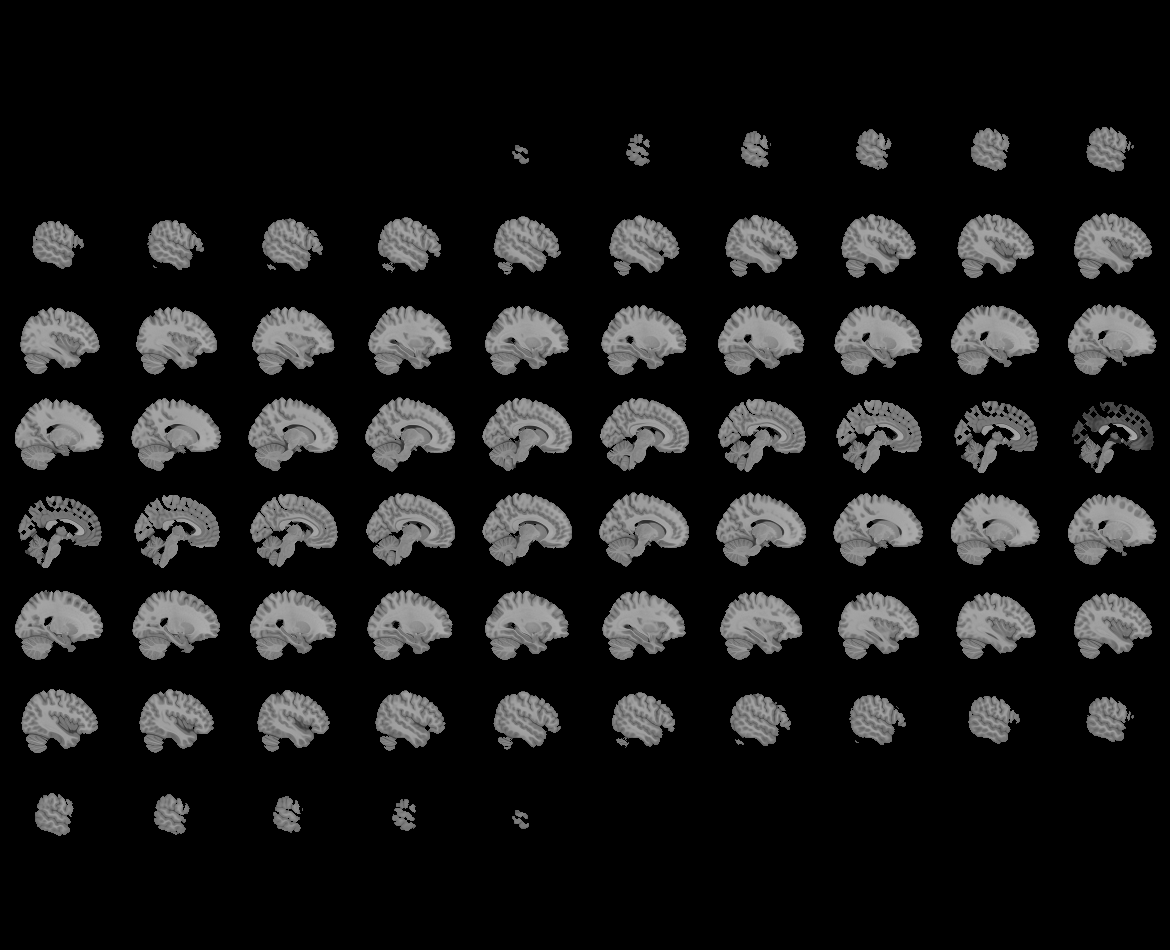
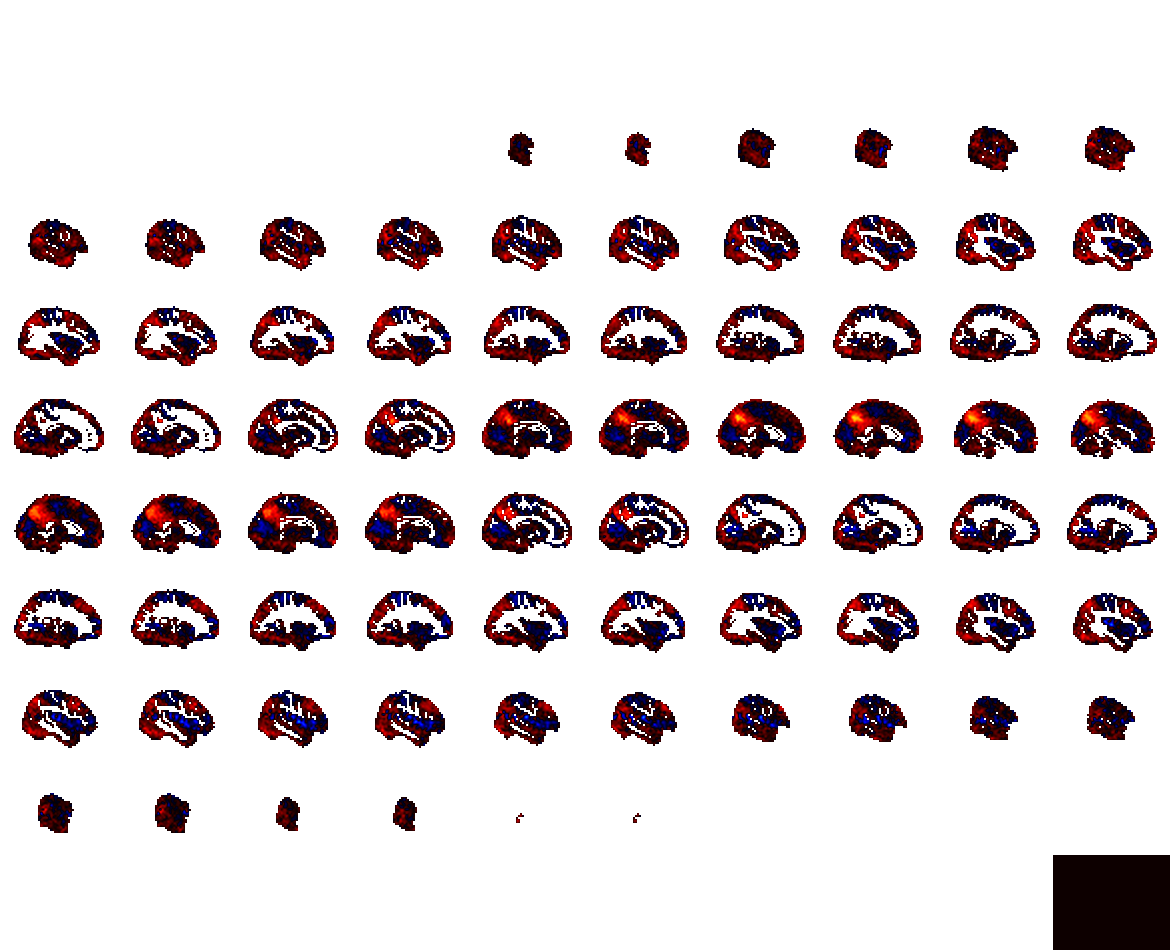

In [9]:
img_r = model.compress(img)
plotting.view_img(image.index_img(img_r, [num_t]), vmax=4)

It is possible to generate a R2 map, which quantifies the quality of this embedding. It computes the fraction of the variance of fMRI time series captured by the parcels. A score of 1 means perfect approximation. The score can be negative, in which case the parcellation approximation performs worst than the average of the signal. 

[MultiNiftiMasker.transform_imgs] Loading data from Nifti1Image(
shape=(50, 59, 50, 168),
affine=array([[   4.,    0.,    0.,  -96.],
       [   0.,    4.,    0., -132.],
       [   0.,    0.,    4.,  -78.],
       [   0.,    0.,    0.,    1.]])
)
[MultiNiftiMasker.transform_imgs] Smoothing images
[MultiNiftiMasker.transform_imgs] Extracting region signals
[MultiNiftiMasker.transform_imgs] Cleaning extracted signals



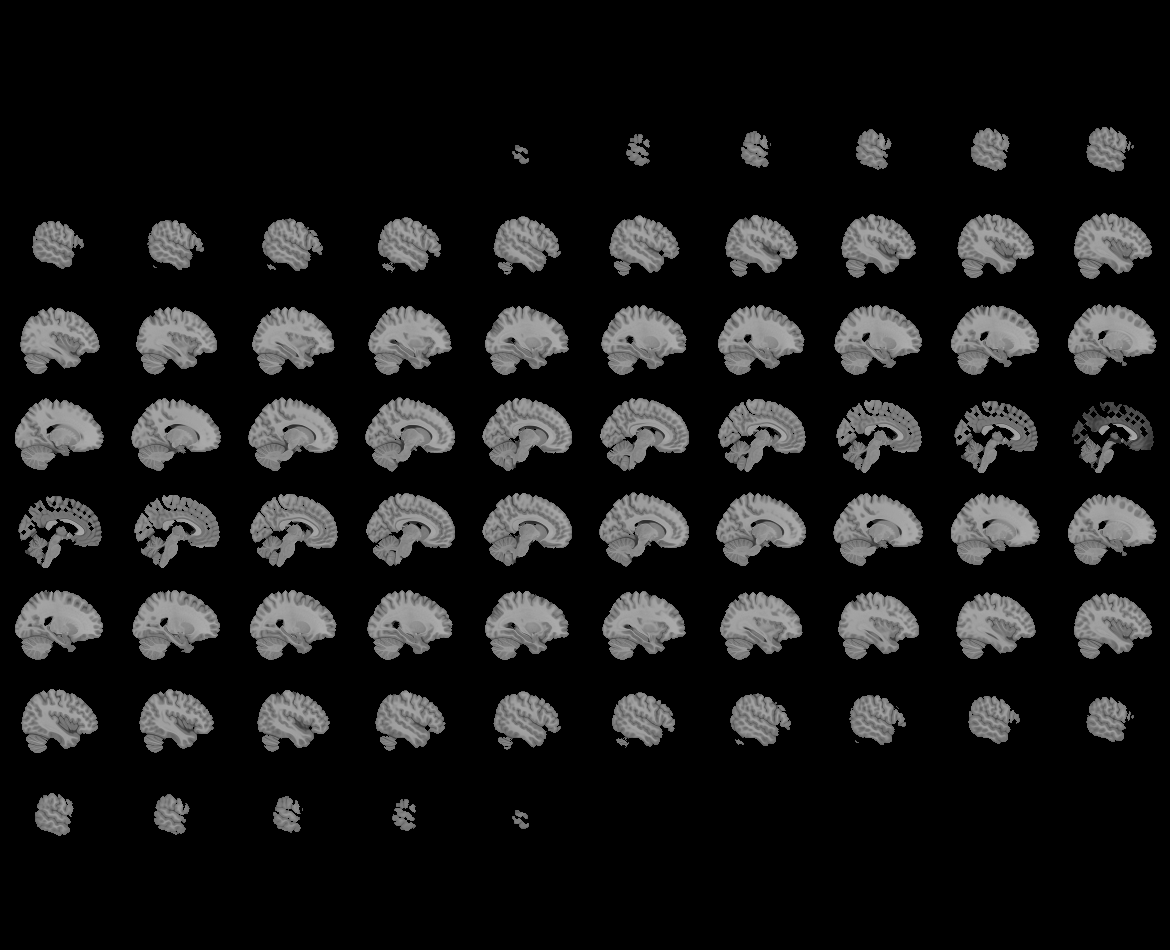
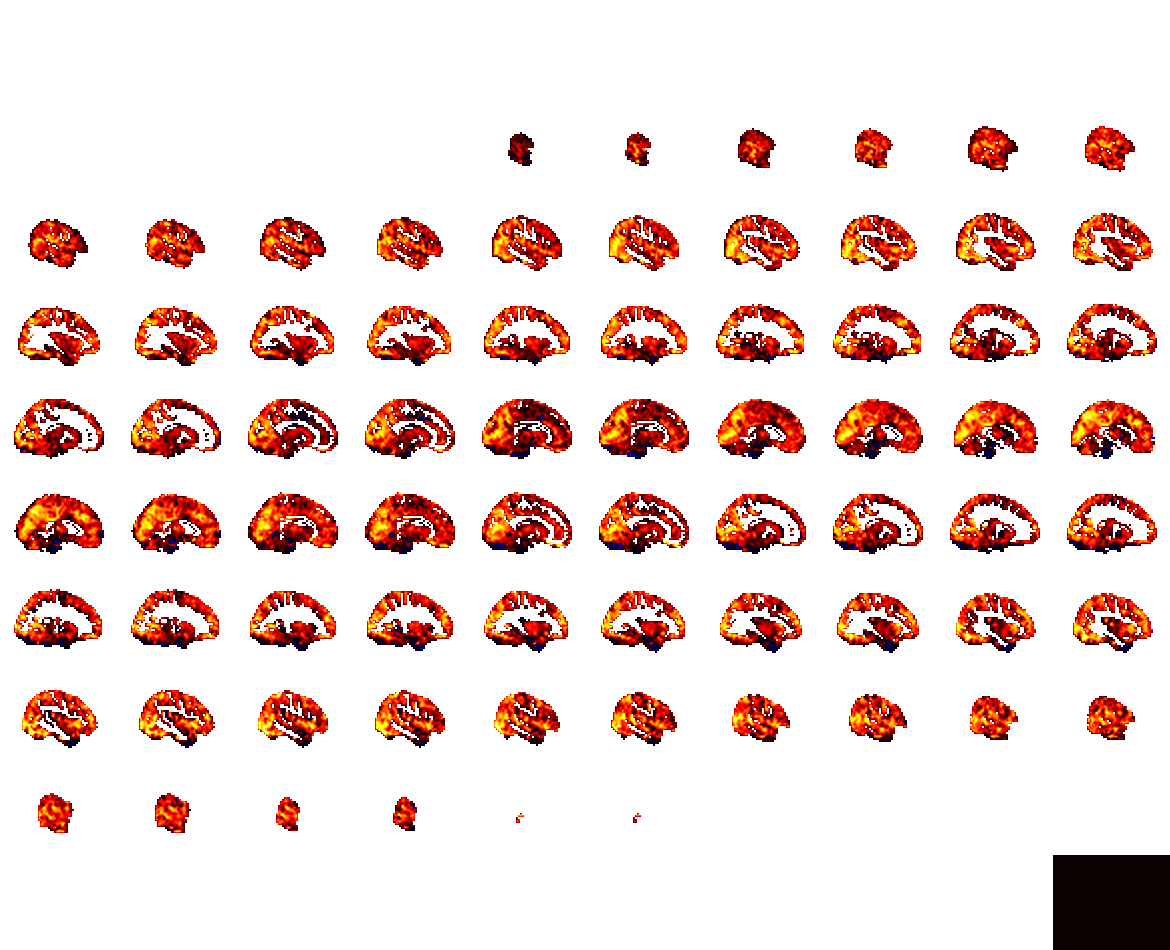

In [10]:
score = model.score(img, conf[0])
plotting.view_img(score, vmax=1)